In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils import shuffle
pad_sequences = keras.preprocessing.sequence.pad_sequences

### Download and Reading the data

This is a shell command that downloads a zip file containing French-English data from a website and extracts its contents using the unzip utility. The first command downloads the file, and the second command extracts it into the current directory.

In [2]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 'replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

Reading the data

In [3]:
lines = pd.read_table('fra.txt', names=['English', 'French','other'])[['English', 'French']]

In [4]:
lines = shuffle(lines)
lines = lines.reset_index(drop=True)
lines.head()

,English,French
0,I don't feel like taking my dog for a walk thi...,Je n'ai pas envie de sortir mon chien ce matin.
1,Tom smiled awkwardly.,Tom sourit maladroitement.
2,I thought that I'd never see you again.,Je pensais que je ne vous reverrais jamais.
3,"You won't go, will you?","Vous n'irez pas, si ?"
4,You're not going to get away with it.,Tu ne vas pas t'en sortir comme ça.


Limiting sample size to be 20000 due to compute limitations

In [5]:
num_samples = 20000 #selects first 20000 rows of pandas df lines
lines = lines.iloc[:num_samples,:]
lines.head()
print("total: {}".format(lines))

total:                                                  English  \
0      I don't feel like taking my dog for a walk thi...   
1                                  Tom smiled awkwardly.   
2                I thought that I'd never see you again.   
3                                You won't go, will you?   
4                  You're not going to get away with it.   
...                                                  ...   
19995                      I never get tired of talking.   
19996              Why did you decide to buy this house?   
19997                              He's out of practice.   
19998                    Do you have any ideas about it?   
19999  She asked him to help her father clean the gar...   

                                                  French  
0        Je n'ai pas envie de sortir mon chien ce matin.  
1                             Tom sourit maladroitement.  
2            Je pensais que je ne vous reverrais jamais.  
3                                  V

### Prepare the Data

The code defines clean_text() function to clean text data and applies it to 'English' and 'French' columns of a pandas DataFrame lines. It removes punctuation, digits, converts to lowercase, and adds tokens to 'French' column.

In [6]:
# Define a function to clean the text
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join(c for c in text if not c.isdigit())
    text = text.strip()
    return text

# Clean the text in the 'English' column
lines['English'] = lines['English'].apply(clean_text)

# Clean the text in the 'French' column, and add start and end tokens
lines['French'] = lines['French'].apply(clean_text)
lines['French'] = 'START_ ' + lines['French'] + ' _END'

lines.head()

,English,French
0,i dont feel like taking my dog for a walk this...,START_ je nai pas envie de sortir mon chien ce...
1,tom smiled awkwardly,START_ tom sourit maladroitement _END
2,i thought that id never see you again,START_ je pensais que je ne vous reverrais jam...
3,you wont go will you,START_ vous nirez pas si _END
4,youre not going to get away with it,START_ tu ne vas pas ten sortir comme ça _END


This code extracts unique words from text to create vocabulary sets for English and French. It then creates dictionaries to map words to numbers and adds a padding character to the target set.

In [7]:
# Define a function to extract unique words from a text
def extract_words(text):
    return set(text.split())

# Extract the English and French vocabularies
all_eng_words = set()
all_fre_words = set()
for eng, fre in zip(lines['English'], lines['French']):
    all_eng_words.update(extract_words(eng))
    all_fre_words.update(extract_words(fre))

# Sort the input and target words
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_fre_words))

# Compute the number of unique input and target words
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words) + 1  # Add one for zero padding

# Create a dictionary to convert words to numbers
input_token_index = {word: i+1 for i, word in enumerate(input_words)}
target_token_index = {word: i+1 for i, word in enumerate(target_words)}

# Create a dictionary to convert numbers to words
reverse_input_token_index = {i+1: word for i, word in enumerate(input_words)}
reverse_target_token_index = {i+1: word for i, word in enumerate(target_words)}

# Add the zero padding character to the target dictionary
reverse_target_token_index[num_decoder_tokens] = '_PAD'

In [8]:
# Compute the maximum sequence lengths
max_length_src = np.max(lines['English'].apply(lambda x: len(x.split())))
max_length_tar = np.max(lines['French'].apply(lambda x: len(x.split())))

### Splitting the data

Splitted the English and French text data into training and testing sets with a 90:10 ratio

In [9]:
lines = shuffle(lines)
X, y = lines.English, lines.French
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)
X_train.shape, X_test.shape

((18000,), (2000,))

The generate_batch function loads training data in batches for a machine translation model. It yields batches of one-hot encoded encoder input, decoder input, and decoder target data by mapping words to numerical indices.

In [10]:
# generator function to load the data in batches
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Build the Model

The build_model function constructs a machine translation model that uses an encoder-decoder architecture with LSTM layers. The model takes encoder and decoder input, maps words to embeddings, generates a probability distribution over the target vocabulary, and computes the categorical cross-entropy loss.

In [11]:
def build_model(
    num_encoder_tokens, num_decoder_tokens, latent_dim=128, mname='word_model'
):
    # Encoder
    encoder_inputs = Input(shape=(None,),name="encoder_inputs")
    enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

    # We discard 'encoder_outputs' and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using 'encoder_states' as initial state.
    decoder_inputs = Input(shape=(None,),name="decoder_inputs")
    dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

    # Use a softmax to generate a probability distribution over the target vocabulary for each time step
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the word model that will turn encoder_input_data & decoder_input_data into decoder_target_data
    word_model = Model([encoder_inputs, decoder_inputs], decoder_outputs ,name=mname )
    # Compile the model
    word_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    return word_model, encoder_states,  encoder_inputs, dec_emb_layer, decoder_inputs, decoder_lstm, decoder_dense

The code modifies the latent dimensionality hyperparameter to 256, calls the build_model function with updated parameters, and prints the model summary.

In [12]:
latent_dim=256

word_model, encoder_states, encoder_inputs, dec_emb_layer, decoder_inputs, decoder_lstm, decoder_dense = build_model(
    num_encoder_tokens=num_encoder_tokens,
    num_decoder_tokens=num_decoder_tokens,
    latent_dim=latent_dim,  # Latent dimensionality of the encoding space.
    mname='word_model'
)
word_model.summary()

Model: "word_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1677312     ['encoder_inputs[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2812928     ['decoder_inputs[0][0]']         
                                                                                         

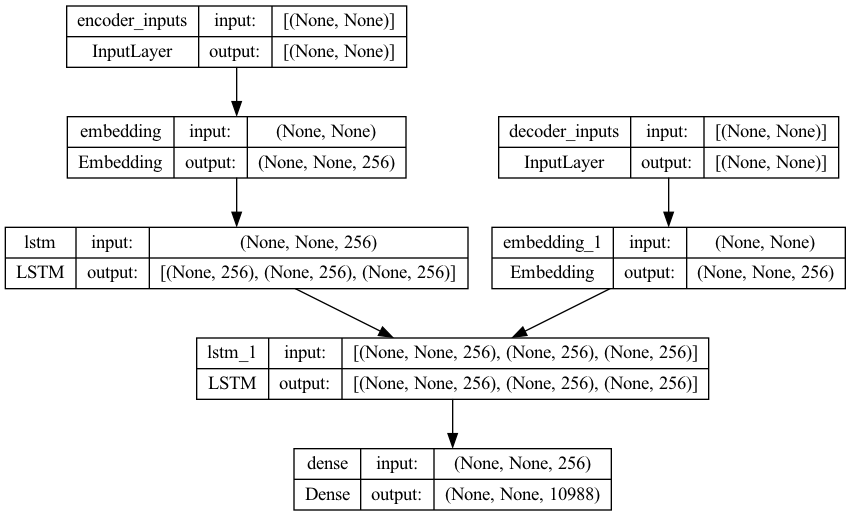

In [13]:
plot_model(word_model, to_file='train_word_model.png', show_shapes=True)

The code trains the word_model using fit_generator() with the specified number of epochs and batch size, using generate_batch() to load the data in batches. It also specifies the number of steps per epoch and validation steps. The training history is stored in the history variable.

In [14]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 100

history = word_model.fit_generator(generator=generate_batch(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=train_samples//batch_size,
                    epochs=epochs,
                    validation_data=generate_batch(X_test, y_test, batch_size=batch_size),
                    validation_steps=val_samples//batch_size
        )

Epoch 1/100


<ipython-input-14-16afaf7e4b73>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = word_model.fit_generator(generator=generate_batch(X_train, y_train, batch_size=batch_size),


281/281 [==============================] - 73s 243ms/step - loss: 0.7583 - acc: 0.1777 - val_loss: 0.7099 - val_acc: 0.2006
Epoch 2/100
281/281 [==============================] - 70s 228ms/step - loss: 0.6711 - acc: 0.2165 - val_loss: 0.6645 - val_acc: 0.2322
Epoch 3/100
281/281 [==============================] - 70s 249ms/step - loss: 0.6302 - acc: 0.2396 - val_loss: 0.6427 - val_acc: 0.2476
Epoch 4/100
281/281 [==============================] - 75s 266ms/step - loss: 0.6010 - acc: 0.2545 - val_loss: 0.6282 - val_acc: 0.2565
Epoch 5/100
281/281 [==============================] - 73s 259ms/step - loss: 0.5781 - acc: 0.2659 - val_loss: 0.6188 - val_acc: 0.2622
Epoch 6/100
281/281 [==============================] - 82s 291ms/step - loss: 0.5603 - acc: 0.2746 - val_loss: 0.6131 - val_acc: 0.2683
Epoch 7/100
281/281 [==============================] - 76s 269ms/step - loss: 0.5452 - acc: 0.2827 - val_loss: 0.6117 - val_acc: 0.2734
Epoch 8/100
281/281 [==============================] - 75s 2

The save_model function saves the trained word_model as JSON and weights to separate files.

In [15]:

# save_model
def save_model(word_model):
    model_json = word_model.to_json()
    with open("model_2.json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    word_model.save_weights("model_weight_5.h5")
    print("Saved word model to disk")


In [16]:
save_model(word_model)

Saved word model to disk


This code block loads the saved model architecture and assigns the saved weights to the model.

In [17]:

# loading the model architecture and asigning the weights
def load_model():
    json_file = open('model_2.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_loaded = model_from_json(loaded_model_json)
    # load weights into new model
    model_loaded.load_weights("model_weight_5.h5")
    return model_loaded
    


In [18]:
model_loaded = load_model()

### Plot Model

The plot_history_models function takes a list of trained model histories and plots the training and validation loss/accuracy for each model over epochs. It also sets the x and y-axis labels and legend.

In [19]:
def plot_history_models(histories, key='loss', ylim=[0, 1]):
    plt.figure(figsize=(7,5), dpi=150)
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
            '--', label=name.title()+' Val')
        plt.plot(
            history.epoch, history.history[key], color=val[0].get_color(), label=name.title()+' Train')
    
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.ylim(ylim)
    plt.grid()

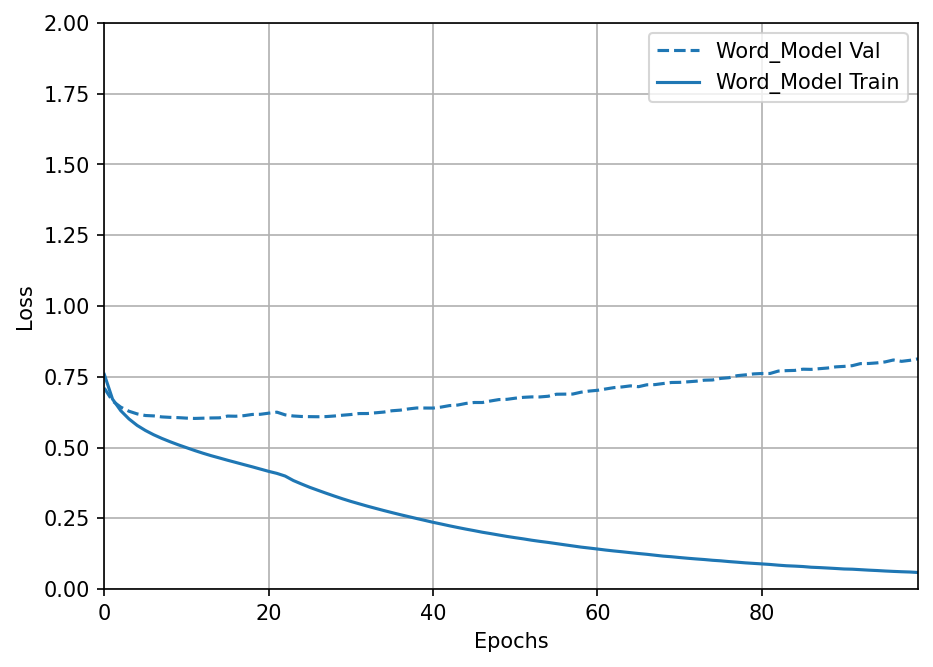

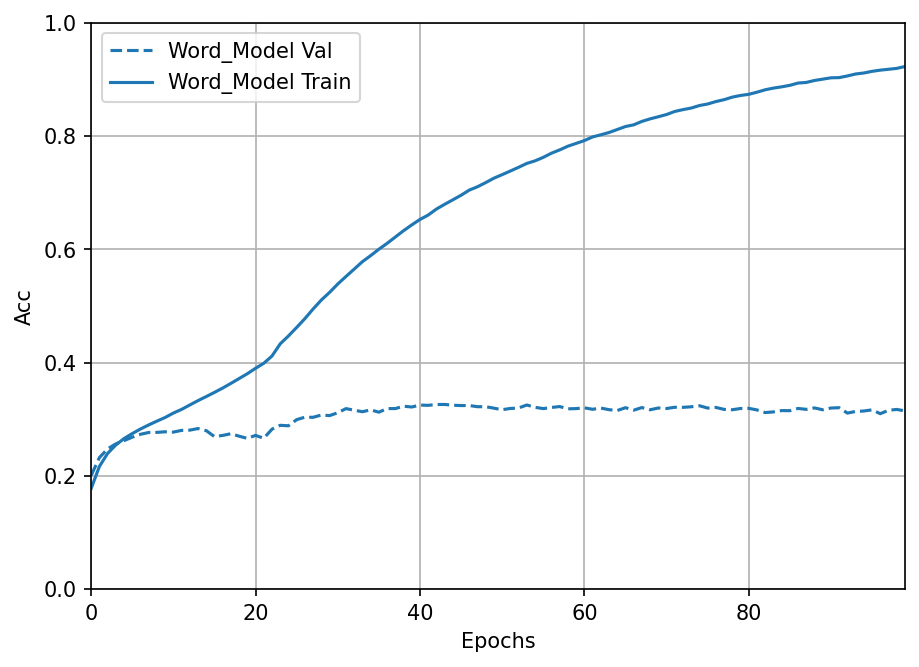

In [20]:
histories_to_plot = [('word_model', history)]
plot_history_models(histories_to_plot, key='loss', ylim=[0, 2.0])
plot_history_models(histories_to_plot, key='acc', ylim=[0, 1.0])

The current situation indicates that the model is overfitting since the training accuracy is higher than the validation accuracy. However, this is primarily due to limitations in computing resources, and we had to use a limited dataset of 20,000 samples, which was split into training and testing sets. To enhance the model's performance, one solution could be to increase the sample size, which could enable the model to identify more intricate patterns and relationships in the data. Alternatively, we could also explore optimizing the model's architecture or hyperparameters to improve its performance without necessarily requiring a larger dataset.

### Encoder Decoder

The code below sets up the decoder for the sequence-to-sequence model. It defines a separate model for the encoder and decoder parts of the model. The decoder takes the encoder's output as input and produces a sequence of outputs. It uses the LSTM layer to generate the sequence and a dense softmax layer to generate probability distribution over the target vocabulary. The decoder is trained to predict the next word in the sequence based on the previous words and the encoder's output.

In [21]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states, name='word_model')
encoder_model.summary()

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


Model: "word_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, None)]           0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1677312   
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 2,202,624
Trainable params: 2,202,624
Non-trainable params: 0
_________________________________________________________________


This function predicts the translation of an input sentence by encoding it as state vectors, generating a target sequence, and sampling output tokens until the stop condition is reached or the maximum length is exceeded.

In [22]:
# Code to predict the input sentences translation
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    #print("target_seq:=>",target_seq)
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '_END' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [23]:
X_test = X_test.reset_index()
y_test = y_test.reset_index()

The code predicts translations for some test sentences using the encoder-decoder model, and prints both the original and predicted translations

In [24]:
def tokenizer_(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    return tokenizer

tokenizer_input = tokenizer_(X_train)

for i in range(10):
    sentence = X_test.iloc[i, 1]
    original_target = y_test.iloc[i, 1]
    #input_seq = target_token_index.texts_to_sequences([sentence])
    input_seq = tokenizer_input.texts_to_sequences([sentence])
    pad_sequence = pad_sequences(input_seq, maxlen= 30, padding='post')
    predicted_target = decode_sequence(pad_sequence)
    print("Test sentence: ",i+1)
    print("sentence: ",sentence)
    print("original translate:",original_target[6:-4]) #don't print start and end
    print("predicted Translate:",predicted_target[:-4]) ##don't print end
    print("=="*50)

1/1 [==============================] - 0s 15ms/step
Test sentence:  1
sentence:  theres no need to decide just yet
original translate:  inutile de se décider tout de suite 
predicted Translate:  la vie est désolée de ne vous pas comme vous êtes sou
1/1 [==============================] - 0s 14ms/step
Test sentence:  2
sentence:  you never told me that yes i did
original translate:  « vous ne mavez jamais dit ça  » « si je lai dit  » 
predicted Translate:  il y a une carte dans cette voiture 
1/1 [==============================] - 0s 13ms/step
Test sentence:  3
sentence:  neither of those things happened
original translate:  aucune de ces choses ne sest produite 
predicted Translate:  donnezmoi la même chose 
1/1 [==============================] - 0s 14ms/step
Test sentence:  4
sentence:  i dont have any trouble believing that
original translate:  je nai aucun problème à croire ça 
predicted Translate:  « le temps grand » « non je te pense » 
1/1 [==============================] - 0s 13m